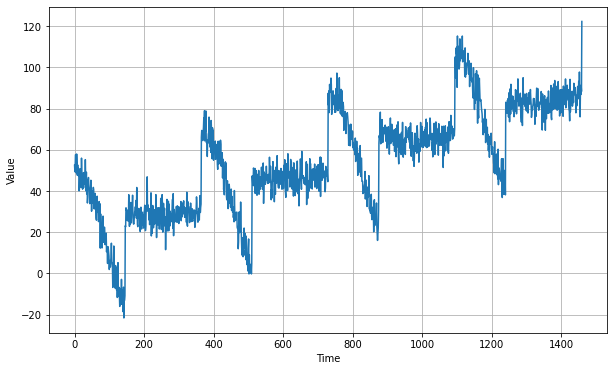

In [7]:
import numpy as np
import matplotlib.pylab as plt
from tensorflow import keras


def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period / period)
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
basline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(
    time, period=365, amplitude=amplitude)
# Updata with noise
series += noise(time, noise_level, seed=42)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [8]:

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [9]:

import tensorflow as tf


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))

    return ds.batch(batch_size).prefetch(1)

In [22]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

D:\Python\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


(1e-08, 0.0001, 0.0, 30.0)

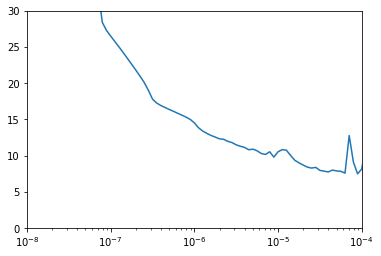

In [54]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train,
                           window_size,
                           batch_size=batch_size,
                           shuffle_buffer=shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=5,
                           strides=1,
                           padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=0)

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# Bi-Directional LSTM

Text(0.5, 1.0, 'mae=5.46705436706543')

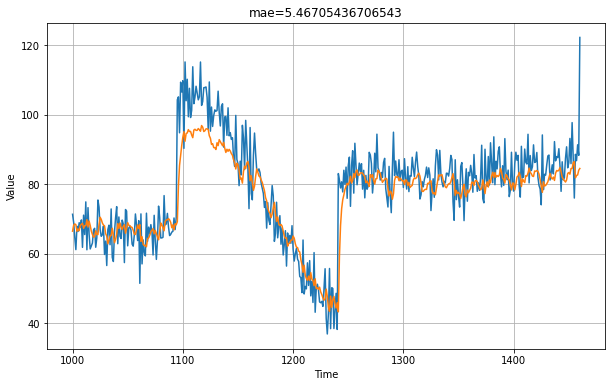

In [55]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train,
                           window_size,
                           batch_size=batch_size,
                           shuffle_buffer=shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=3,
                           strides=1,
                           padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

history = model.fit(dataset, epochs=500, verbose=0)

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

plt.title(f'mae={tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()}')

In [52]:
print(series.shape)
series[..., np.newaxis].shape

(1461,)


(1461, 1)